<a href="https://colab.research.google.com/github/MichalWlodkowski/US_speeches/blob/master/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install scrapy
from scrapy import Selector
import requests
import numpy as np
import pandas as pd
import re

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize

import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
us_all = 'https://en.wikisource.org/wiki/Portal:Inaugural_Speeches_by_United_States_Presidents'

In [0]:
## Getting links to all presidential Inaugural Addresses in US

html = requests.get(us_all).content
sel = Selector( text = html )
xpath3 = '//@href'
d = pd.DataFrame(sel.xpath(xpath3).extract())
speech = d[d[0].str.contains('Inaugural_Address')].reset_index(drop = True)
speech.columns = ['links']

In [15]:
# Function to get president name from links + receiving full link for speeches
def frag(x):
    wh = x[6:x.find('%')].replace('_',' ')
    return wh
speech['president'] = speech['links'].apply(frag)
speech['full_links'] = speech['links'].apply(lambda x: 'https://en.wikisource.org' + x)
speech[['president','links','full_links']].head()

,president,links,full_links
0,George Washington,/wiki/George_Washington%27s_First_Inaugural_Ad...,https://en.wikisource.org/wiki/George_Washingt...
1,George Washington,/wiki/George_Washington%27s_Second_Inaugural_A...,https://en.wikisource.org/wiki/George_Washingt...
2,John Adams,/wiki/John_Adams%27_Inaugural_Address,https://en.wikisource.org/wiki/John_Adams%27_I...
3,Thomas Jefferson,/wiki/Thomas_Jefferson%27s_First_Inaugural_Add...,https://en.wikisource.org/wiki/Thomas_Jefferso...
4,Thomas Jefferson,/wiki/Thomas_Jefferson%27s_Second_Inaugural_Ad...,https://en.wikisource.org/wiki/Thomas_Jefferso...


In [0]:
plain_text = []

#for each in range(len(speech)-3,len(speech)):
for each in range(len(speech)):
    
    html = requests.get(speech.full_links.loc[each]).content
    sel = Selector (text = html)
    xpath3 = '//*[@class="mw-parser-output"]//p//text()'
    # Extract text from website + join in 1string + remove unwanted text and new lines
    text = ''.join(sel.xpath(xpath3).extract()).replace('\nThis work is in the public domain in the United States because it is a work of the United States federal government (see 17\xa0U.S.C.\xa0105).\n','')\
.replace('\n',' ')
    text_lines = ''.join(sel.xpath(xpath3).extract()).replace('\nThis work is in the public domain in the United States because it is a work of the United States federal government (see 17\xa0U.S.C.\xa0105).\n','')
    plain_text.append(text)   

In [0]:
def hm_words(x):
    words = len(x.split())
    return words

def hm_ch_words(x):
    words_ch = round(np.mean([len(x) for x in x.split()]),2)
    return words_ch

def n_sentences(x):
    sent = len(x.split('.'))
    return sent


In [18]:
speeches = pd.DataFrame(plain_text, columns = ['speeches'])
speeches['characters'] = speeches.speeches.apply(len)
speeches['words'] = speeches.speeches.apply(hm_words)
speeches['ch_in_words'] = speeches.speeches.apply(hm_ch_words)
speeches['sentences'] = speeches.speeches.apply(n_sentences)

speeches['ch_in_sent'] = round(speeches['characters'] / speeches['sentences'],1)
speeches = pd.concat([speech['president'],speeches.iloc[:,1:]], axis = 1)
speeches['n'] = speeches.groupby('president').cumcount() + 1
speeches.tail(5)

,president,characters,words,ch_in_words,sentences,ch_in_sent,n
53,George W. Bush,9005,1586,4.68,84,107.2,1
54,George W. Bush,11918,2083,4.72,104,114.6,2
55,Barack Obama,13140,2328,4.64,109,120.6,1
56,Barack Obama,11954,2114,4.65,86,139.0,2
57,Donald Trump,8413,1456,4.78,96,87.6,1


In [19]:
double = speeches[speeches['n'] == 2].president
double_stats = speeches[(speeches['president'].isin(double))&speeches['n'].isin([1,2])].groupby('n').agg({'words':['mean','std'],'sentences':['mean','std'],\
                                                                                           'ch_in_sent':['mean','std'],'characters':['mean','std'],\
                                                                                           'ch_in_words':['mean','std']}).round(1).T
double_stats['diff'] = double_stats[2]-double_stats[1]
double_stats

n                       1        2    diff
words       mean   2084.3   1827.1  -257.2
            std     881.8    912.6    30.8
sentences   mean     80.4     71.4    -9.0
            std      40.5     37.3    -3.2
ch_in_sent  mean    177.6    161.5   -16.1
            std      76.5     55.7   -20.8
characters  mean  12090.0  10595.5 -1494.5
            std    5200.0   5385.9   185.9
ch_in_words mean      4.8      4.8     0.0
            std       0.2      0.2     0.0

In [20]:
double_stats2 = speeches[(speeches['president'].isin(double))&speeches['n'].isin([1,2])].groupby('n').agg({'words':['median','std'],'sentences':['median','std'],\
                                                                                           'ch_in_sent':['median','std'],'characters':['median','std'],\
                                                                                           'ch_in_words':['median','std']}).round(1).T
double_stats2['diff'] = double_stats2[2]-double_stats2[1]
double_pres = speeches[(speeches['president'].isin(double))&speeches['n'].isin([1,2])]
double_stats2


n                         1        2   diff
words       median   1718.0   1800.0   82.0
            std       881.8    912.6   30.8
sentences   median     87.0     70.0  -17.0
            std        40.5     37.3   -3.2
ch_in_sent  median    161.8    139.4  -22.4
            std        76.5     55.7  -20.8
characters  median  10120.0  10582.0  462.0
            std      5200.0   5385.9  185.9
ch_in_words median      4.8      4.8    0.0
            std         0.2      0.2    0.0

In [21]:
speeches.groupby(['president']).median().sort_values('words', ascending = False).head()

,characters,words,ch_in_words,sentences,ch_in_sent,n
president,,,,,,
William Henry Harrison,49652.0,8424.0,4.89,213.0,233.1,1.0
William Howard Taft,32119.0,5428.0,4.92,161.0,199.5,1.0
James K. Polk,28695.0,4793.0,4.98,147.0,195.2,1.0
Benjamin Harrison,26195.0,4392.0,4.96,153.0,171.2,1.0
Calvin Coolidge,23946.0,4056.0,4.90,197.0,121.6,1.0


In [22]:
double_pres[['president','characters','n']].pivot(index='president',columns='n')

characters       
n                           1      2
president                           
Abraham Lincoln         22133   4019
Andrew Jackson           6799   7044
Barack Obama            13140  11954
Bill Clinton             9014  12168
Dwight Eisenhower       13864   9102
Franklin Roosevelt      10987  10582
George W. Bush           9005  11918
George Washington        8678    786
Grover Cleveland        10120  12325
James Madison            6988   7146
James Monroe            19827  26298
Richard Nixon           11490   9892
Ronald Reagan           13712  14496
Thomas Jefferson        10120  12902
Ulysses S. Grant         6474   7708
William McKinley        23626  13416
Woodrow Wilson           9553   8367

In [0]:
html = requests.get('https://en.wikisource.org/wiki/Portal:Inaugural_Speeches_by_United_States_Presidents').content
sel = Selector (text = html)
xpath3 = '//*[@class="mw-parser-output"]//ul//li//a/text()'
    # Extract text from website + join in 1string + remove unwanted text and new lines
text = sel.xpath(xpath3).extract()

In [0]:
years = pd.DataFrame([int(t) for t in text if len(t)==4])
speeches_y = pd.concat([speeches,years], axis = 1)

In [0]:
import matplotlib.pyplot as plt

In [41]:
doubled_characters = pd.DataFrame(double_pres[['president','characters','n']].pivot(index='president',columns='n').to_records())
doubled_characters.columns = ['president','n1','n2']
doubled_characters['diff'] = doubled_characters['n2']-doubled_characters['n1']
doubled_characters['diff_p'] = doubled_characters['diff']/doubled_characters['n1']
doubled_characters.sort_values(by='diff', ascending = False).round(3)


,president,n1,n2,diff,diff_p
10,James Monroe,19827,26298,6471,0.326
3,Bill Clinton,9014,12168,3154,0.350
6,George W. Bush,9005,11918,2913,0.323
13,Thomas Jefferson,10120,12902,2782,0.275
8,Grover Cleveland,10120,12325,2205,0.218
14,Ulysses S. Grant,6474,7708,1234,0.191
12,Ronald Reagan,13712,14496,784,0.057
1,Andrew Jackson,6799,7044,245,0.036
9,James Madison,6988,7146,158,0.023
5,Franklin Roosevelt,10987,10582,-405,-0.037


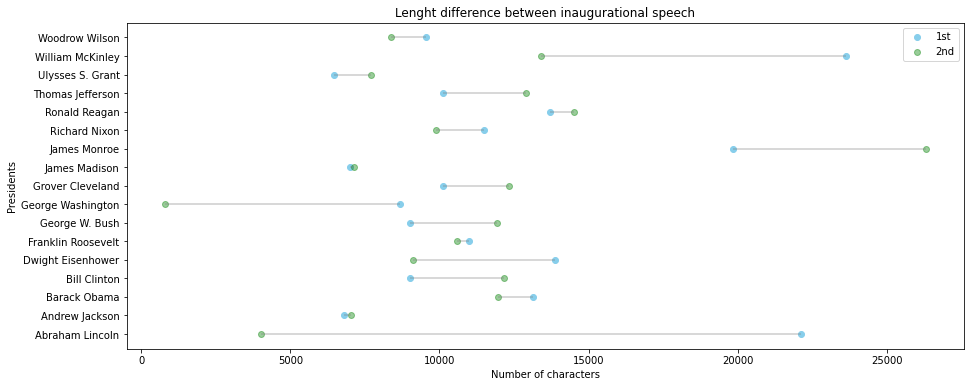

In [54]:
# Lollipop horizontal with two groups:
 
my_range=range(1,len(doubled_characters.index)+1)

plt.figure(figsize =(15,6))
plt.hlines(y=my_range, xmin=doubled_characters['n1'], xmax=doubled_characters['n2'], color='grey', alpha=0.4)
plt.scatter(doubled_characters['n1'], my_range, color='skyblue', alpha=1, label='1st')
plt.scatter(doubled_characters['n2'], my_range, color='green', alpha=0.4 , label='2nd')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, doubled_characters['president'])
plt.title("Lenght difference between inaugurational speech", loc='center')
plt.xlabel('Number of characters')
plt.ylabel('Presidents')

plt.show()

In [56]:
speeches.groupby(['president']).median().sort_values('words', ascending = False).head()

,characters,words,ch_in_words,sentences,ch_in_sent,n
president,,,,,,
William Henry Harrison,49652.0,8424.0,4.89,213.0,233.1,1.0
William Howard Taft,32119.0,5428.0,4.92,161.0,199.5,1.0
James K. Polk,28695.0,4793.0,4.98,147.0,195.2,1.0
Benjamin Harrison,26195.0,4392.0,4.96,153.0,171.2,1.0
Calvin Coolidge,23946.0,4056.0,4.90,197.0,121.6,1.0


In [55]:
doubled_characters = pd.DataFrame(double_pres[['president','characters','n']].pivot(index='president',columns='n').to_records())
doubled_characters.columns = ['president','n1','n2']
doubled_characters['diff'] = doubled_characters['n2']-doubled_characters['n1']
doubled_characters['diff_p'] = doubled_characters['diff']/doubled_characters['n1']
doubled_characters.sort_values(by='diff', ascending = False).round(3)


,president,n1,n2,diff,diff_p
10,James Monroe,19827,26298,6471,0.326
3,Bill Clinton,9014,12168,3154,0.350
6,George W. Bush,9005,11918,2913,0.323
13,Thomas Jefferson,10120,12902,2782,0.275
8,Grover Cleveland,10120,12325,2205,0.218
14,Ulysses S. Grant,6474,7708,1234,0.191
12,Ronald Reagan,13712,14496,784,0.057
1,Andrew Jackson,6799,7044,245,0.036
9,James Madison,6988,7146,158,0.023
5,Franklin Roosevelt,10987,10582,-405,-0.037


In [0]:
## 1 next steps: create Lolipop for Presidents double (sentences, words ) median
#b) write function to do Lolipop, and function to preprocess data for lolipop
## 2 next steps: dodaj rok do mów inauguracyjnych                                                 ###done

### 4 next step: zmierz podobienstwo między prezydentami....
### 5 next step: analiza sentymentu (pozytywne negatywne)